In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mode, mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('../input/heart-disease-prediction-using-logistic-regression/framingham.csv')

### Clearing data ###

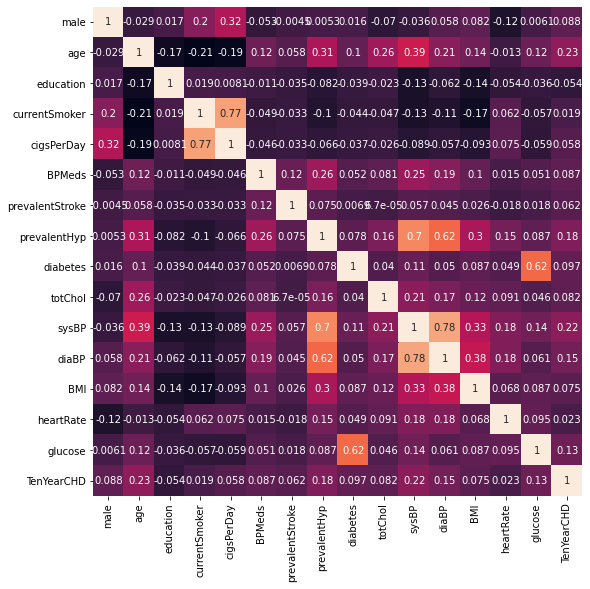

In [3]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(data.corr(), square=True, annot=True, cbar=False,  ax=ax);
# and we can see that here no height correlation

In [4]:
data.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Delete from data that rows where >=2 no data available.

In [5]:
data = data.dropna(axis='rows', thresh=15)
data.isnull().sum()

male                 0
age                  0
education           93
currentSmoker        0
cigsPerDay          23
BPMeds              51
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              9
sysBP                0
diaBP                0
BMI                 13
heartRate            1
glucose            331
TenYearCHD           0
dtype: int64

So we have categorical data:
- education
- BPMeds
To fill data by mode.

Continuous data:
- cigsPerDay
- totChol
- BMI
- heartRate
- glucose
To fill data by mean.

In [6]:
data["education"]=data["education"].fillna(mode(data["education"]))
data["BPMeds"]=data["BPMeds"].fillna(mode(data["BPMeds"]))

data["cigsPerDay"]=data["cigsPerDay"].fillna((data["cigsPerDay"].mean()))
data["totChol"]=data["totChol"].fillna((data["totChol"].mean()))
data["BMI"]=data["BMI"].fillna((data["BMI"].mean()))
data["heartRate"]=data["heartRate"].fillna((data["heartRate"].mean()))
data["glucose"]=data["glucose"].fillna(data["glucose"].mean())

In [7]:
data.isnull().any()

male               False
age                False
education          False
currentSmoker      False
cigsPerDay         False
BPMeds             False
prevalentStroke    False
prevalentHyp       False
diabetes           False
totChol            False
sysBP              False
diaBP              False
BMI                False
heartRate          False
glucose            False
TenYearCHD         False
dtype: bool

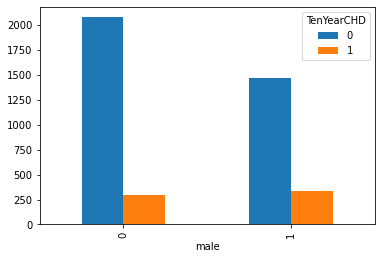

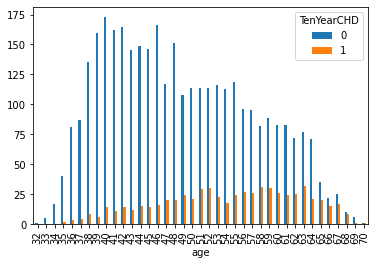

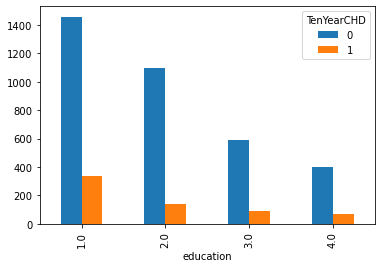

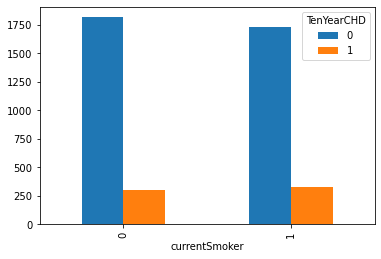

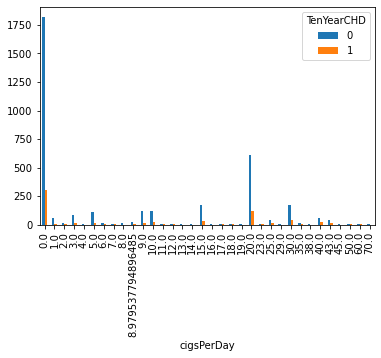

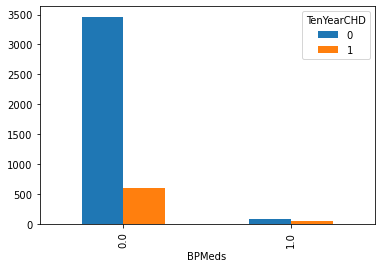

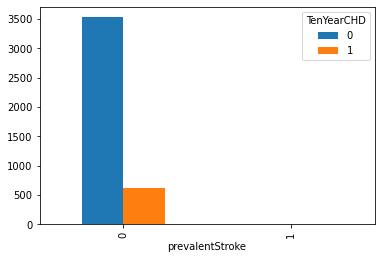

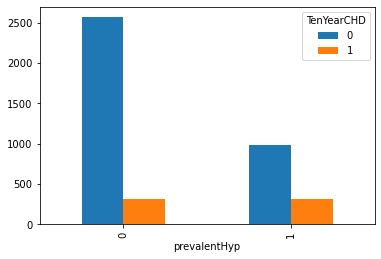

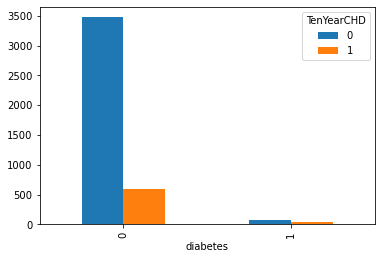

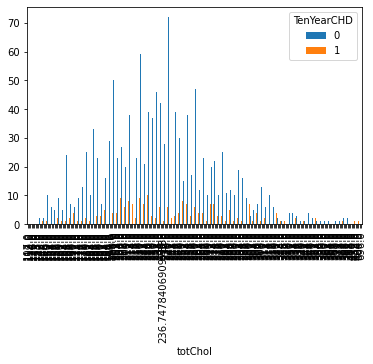

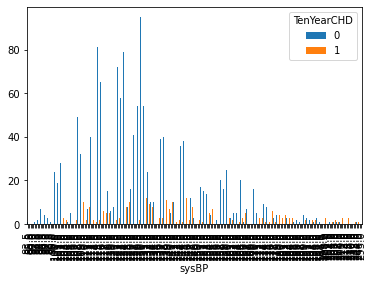

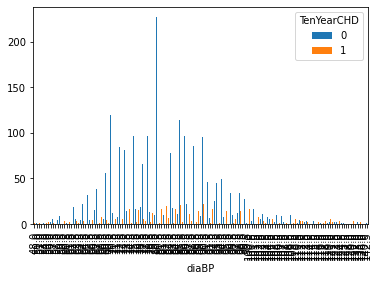

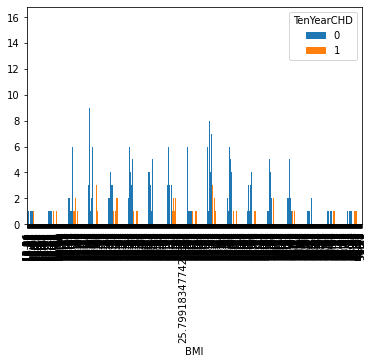

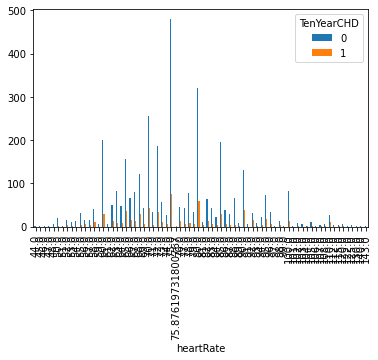

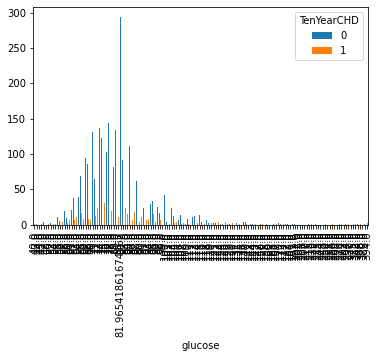

In [8]:
for col in data.columns[:-1]:
    pd.crosstab(data[col], data.TenYearCHD).plot(kind='bar')
    plt.xlabel(col)

Only 'currentSmoker' not be a good predictor of the outcome.

In [9]:
data = data.drop(columns='currentSmoker')

In [10]:
X = data[['male','age','education','cigsPerDay','BPMeds','prevalentStroke','prevalentHyp','diabetes','totChol','sysBP','diaBP','BMI','heartRate','glucose']]
y = pd.Series(data['TenYearCHD'])

### Train model ###

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

We need to normalize our data, and shift the mean to the origin. This is important to get accurate results because of the nature of the logistic equation. This is done by the normalize method.
StandardScaler transforms the data in such a manner that it has mean as 0 and standard deviation as 1. In short, it standardizes the data. 

Check that the mean of each feature (column) is 0

In [13]:
np.around(X_train.mean(axis = 0), 10)

array([ 0.,  0.,  0., -0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,  0.,
        0.])

Check that the std of each feature (column) is 1

In [14]:
X_train.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
model = LogisticRegression()

In [16]:
model.fit(X_train, y_train);

In [17]:
labels = model.predict(X_test)

In [18]:
accuracy_score(y_test, labels)

0.8563734290843806

### Research model ###

It is the best score in this model and you will see why we stay on it:
Creating an array containing labels depending on the specified threshold and looking at the results classification_report.

In [19]:
acc = np.array([])
for i in range(0, 100, 10):
    y_pred_new_threshold = (model.predict_proba(X_test)[:, 1]>= i/100).astype(int)
    newscore = accuracy_score(y_test, y_pred_new_threshold)
    acc = np.append(acc, [y_pred_new_threshold])
acc = acc.astype(int)
acc = acc.reshape(10,-1)

In [20]:
i=0
for l in acc:
    print('***', i, '***')
    matrix = confusion_matrix(y_test, l)
    print('\n', matrix)
    print(classification_report(y_test, l))
    i+=1

*** 0 ***

 [[   0 1417]
 [   0  254]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1417
           1       0.15      1.00      0.26       254

    accuracy                           0.15      1671
   macro avg       0.08      0.50      0.13      1671
weighted avg       0.02      0.15      0.04      1671

*** 1 ***

 [[679 738]
 [ 53 201]]
              precision    recall  f1-score   support

           0       0.93      0.48      0.63      1417
           1       0.21      0.79      0.34       254

    accuracy                           0.53      1671
   macro avg       0.57      0.64      0.48      1671
weighted avg       0.82      0.53      0.59      1671

*** 2 ***

 [[1117  300]
 [ 115  139]]
              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1417
           1       0.32      0.55      0.40       254

    accuracy                           0.75      1671
   macro avg   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


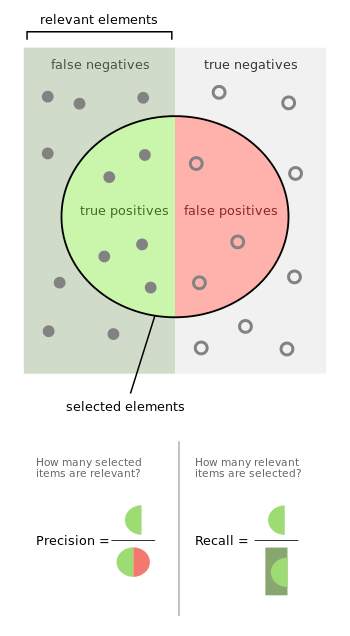

In some situations it is possible to maximize either recall or precision at the expense of another metric. For example, when pre-screening patients for follow — up, we would probably like to get a review of about 1.0-we want to find all patients who actually have the disease and we can accept low accuracy if the cost of follow-up is not significant. However, there is a simpler metric that takes into account both accuracy and recall, and so you can aim to maximize this number to make the model better. This F1-score that is a harmonic mean of precision and recall.
**And now we see that F-1-score of model = 86%**.
So it is better result who don`t have disease. And for creatind better model to need more data.

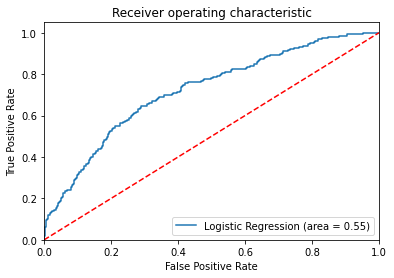

In [21]:
logit_roc_auc = roc_auc_score(y_test, labels)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()